# EDA for NCAA March Madness

### [EDA](#EDA)
 [- MTeams](#MTeams)  
 [- MNCAATourneySeeds](#MNCAATourneySeeds)  
 [- MRegularSeasonCompactResults](#MRegularSeasonCompactResults)  
 [- MEvents](#MEvents)  
 [- MPlayers](#MPlayers)

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import re
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set(font_scale=2.2)
sns.set(style="whitegrid")
base_color = sns.color_palette()[0]
second_color = sns.color_palette()[1]
third_color = sns.color_palette()[2]

In [2]:
files = glob.glob('input/MEvents*.csv')

In [3]:
# 'MEvents'로 시작하는 모든 CSV file을 불러오기
data_frames = [pd.read_csv(file) for file in files]

events = pd.concat(data_frames, axis=0, sort=False)
events.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,1,2015,11,1103,1420,74,57,0,0,19,1103,100,miss3,unk,0,0,0
1,2,2015,11,1103,1420,74,57,0,0,19,1420,11784,reb,def,0,0,0
2,3,2015,11,1103,1420,74,57,0,0,27,1420,11789,made2,dunk,0,0,0
3,4,2015,11,1103,1420,74,57,0,0,27,1420,11803,assist,NaN,0,0,0
4,5,2015,11,1103,1420,74,57,0,0,59,1103,87,made2,jump,0,0,0


In [4]:
# 디버깅: True일땐 MEvents 별로 50000개의 행만 랜덤하게 불러옴, False일땐 전체 행을 불러옴
# Reference: https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame

DEBUG = False
if DEBUG:
    sample_size = 50000
else: 
    sample_size = None

def get_skiprows(file, sample_size):
    num_of_records = sum(1 for line in open(file))
    # the 0-indexed header will not be included in the skip list
    if DEBUG:
        skiprows = sorted(random.sample(range(1,num_of_records+1),
                                    num_of_records-sample_size))
    else:
        skiprows=None
    return skiprows

In [5]:
PATH = 'input/'
dfs = {'MEvents': [], 'Misc': {}}
for root, dirs, files in os.walk(PATH):
    for file in files:
        path_and_file = os.path.join(root, file)
        print(path_and_file)
        if bool(re.search('MEvents', path_and_file)):
            skiprows = get_skiprows(path_and_file, sample_size)
            dfs['MEvents'].append(pd.read_csv(path_and_file, skiprows=skiprows))
            
        elif bool(re.search('.DS_Store', path_and_file)):
            pass
        else:
            file_name_start_index = path_and_file.rfind('/') + 1
            file_name_end_index = re.search('.csv', path_and_file).span()[0]
            if bool(re.search('MTeamSpellings', path_and_file)):
                dfs['Misc'][path_and_file[file_name_start_index:file_name_end_index]] = pd.read_csv(path_and_file, encoding='cp1252')
            else: 
                dfs['Misc'][path_and_file[file_name_start_index:file_name_end_index]] = pd.read_csv(path_and_file)                
            

input/MEvents2015.csv
input/MEvents2016.csv
input/MEvents2017.csv
input/MEvents2018.csv
input/MEvents2019.csv
input/MPlayers.csv
input/MSampleSubmissionStage1_2020.csv
input/MDataFiles_Stage1\Cities.csv
input/MDataFiles_Stage1\Conferences.csv
input/MDataFiles_Stage1\MConferenceTourneyGames.csv
input/MDataFiles_Stage1\MGameCities.csv
input/MDataFiles_Stage1\MMasseyOrdinals.csv
input/MDataFiles_Stage1\MNCAATourneyCompactResults.csv
input/MDataFiles_Stage1\MNCAATourneyDetailedResults.csv
input/MDataFiles_Stage1\MNCAATourneySeedRoundSlots.csv
input/MDataFiles_Stage1\MNCAATourneySeeds.csv
input/MDataFiles_Stage1\MNCAATourneySlots.csv
input/MDataFiles_Stage1\MRegularSeasonCompactResults.csv
input/MDataFiles_Stage1\MRegularSeasonDetailedResults.csv
input/MDataFiles_Stage1\MSeasons.csv
input/MDataFiles_Stage1\MSecondaryTourneyCompactResults.csv
input/MDataFiles_Stage1\MSecondaryTourneyTeams.csv
input/MDataFiles_Stage1\MTeamCoaches.csv
input/MDataFiles_Stage1\MTeamConferences.csv
input/MDataFil

# EDA

## MTeams

- `FirstD1Season`: 처음 1부리그에 등장한 시즌
- `LastD1Season`: 1부리그에 있었던 마지막 시즌

In [6]:
MTeams = dfs['Misc']['MDataFiles_Stage1\\MTeams']
MTeams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2020
1,1102,Air Force,1985,2020
2,1103,Akron,1985,2020
3,1104,Alabama,1985,2020
4,1105,Alabama A&M,2000,2020


In [7]:
MTeams.shape

(367, 4)

역대 총 367개의 팀이 존재했습니다. 현재 시즌인 2020시즌에 없는 팀도 모두 포함입니다.

In [8]:
MTeams.sort_values('FirstD1Season', ascending=False).head()

,TeamID,TeamName,FirstD1Season,LastD1Season
366,1467,Merrimack,2020,2020
365,1466,North Alabama,2019,2020
364,1465,Cal Baptist,2019,2020
112,1213,Grand Canyon,2014,2020
161,1262,MA Lowell,2014,2020


`Merrimack`팀은 올해 처음 1부리그로 올라오게 되었습니다.

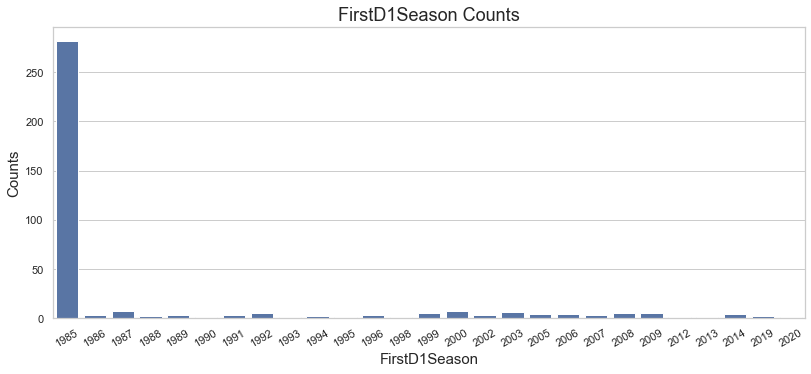

In [9]:
def plot_bar_chart(df, feature):
    plt.figure(figsize=(12, 5))
    counts = df[feature].value_counts()
    sns.barplot(x=counts.index, y=counts.values, color=base_color)


plot_bar_chart(MTeams, 'FirstD1Season')
plt.title('FirstD1Season Counts', fontsize=18); plt.xlabel('FirstD1Season', fontsize=15); plt.ylabel('Counts', fontsize=15)
plt.xticks(rotation=30);

In [10]:
rate_of_FirstD1Season = round(MTeams['FirstD1Season'].value_counts().max() / MTeams.shape[0], 2)
rate_of_FirstD1Season = int(rate_of_FirstD1Season*100)
print(f'{rate_of_FirstD1Season}%의 팀이 1985년 1부리그에 진출했습니다. 1985년 이전에 진출한 팀도 1985년으로 기록되어있음을 유의하시기 바랍니다.')

77%의 팀이 1985년 1부리그에 진출했습니다. 1985년 이전에 진출한 팀도 1985년으로 기록되어있음을 유의하시기 바랍니다.


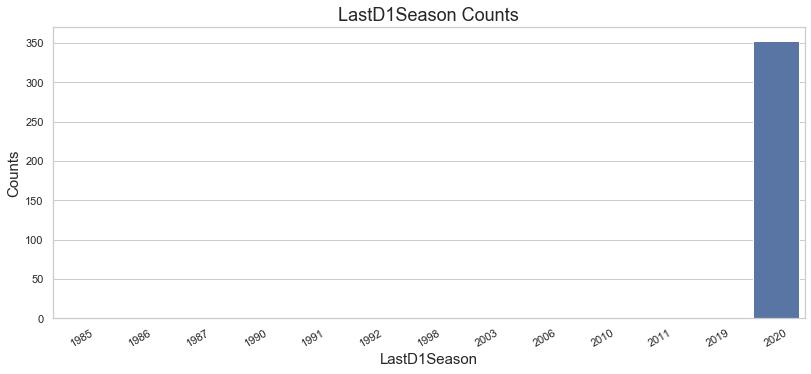

In [11]:
plot_bar_chart(MTeams, 'LastD1Season')
plt.title('LastD1Season Counts', fontsize=18); plt.xlabel('LastD1Season', fontsize=15); plt.ylabel('Counts', fontsize=15)
plt.xticks(rotation=30);

In [12]:
rate_of_LastD1Season = round(MTeams['LastD1Season'].value_counts().max() / MTeams.shape[0], 2)
rate_of_LastD1Season = int(rate_of_LastD1Season*100)
print(f'{rate_of_LastD1Season}%의 팀이 현재까지 남아있습니다.')

96%의 팀이 현재까지 남아있습니다.


## MSeasons

- `MRegularSeasonCompactResults`의 `DayNum`=0인 날

In [13]:
MSeasons = dfs['Misc']['MDataFiles_Stage1\\MSeasons']
MSeasons.head(5)

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [14]:
MSeasons.shape

(36, 6)

## MNCAATourneySeeds

In [15]:
MNCAATourneySeeds = dfs['Misc']['MDataFiles_Stage1\\MNCAATourneySeeds']
MNCAATourneySeeds.head(5)

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [16]:
MNCAATourneySeeds.shape

(2286, 3)

In [17]:
MNCAATourneySeeds['Seed'].value_counts()

W09     35
Z01     35
Y02     35
X09     35
Z08     35
        ..
W12a     1
X12a     1
Z14b     1
X12b     1
Z14a     1
Name: Seed, Length: 90, dtype: int64

## MRegularSeasonCompactResults

selection sunday(`DayNum`==132인 날) 이전의 경기. 즉, 예선전 (pre-season tournament, a non-conference game, a regular conference game)의 경기 결과를 나타내는 데이터

- 고유값: Season-DayNum-WTeamID
특정 날짜에는 한 경기만 열리며, 한 경기에서 승자는 한 팀입니다. Season-DayNum를 통해 경기 날짜를 알 수 있으며, WTeamID를 통해 승리 팀을 알 수 있습니다. 따라서 Season-DayNum-WTeamID는 고유의 Key값이 될 수 있습니다.

 **NOTE**: In order to accomplish this uniqueness, we had to adjust one game's date. In March 2008, the SEC postseason tournament had to reschedule one game (Georgia-Kentucky) to a subsequent day because of a tornado, so Georgia had to actually play two games on the same day. In order to enforce this uniqueness, we moved the game date for the Georgia-Kentucky game back to its original scheduled date.

In [18]:
MRegularSeasonCompactResults = dfs['Misc']['MDataFiles_Stage1\\MRegularSeasonCompactResults']
MRegularSeasonCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [19]:
MRegularSeasonCompactResults.shape

(161552, 8)

### MRegularSeasonCompactResults와 MTeams Merge
승리팀, 패배팀의 팀명을 `MRegularSeasonCompactResults`에 추가합니다.

In [20]:
MRegularSeasonCompactResults = \
    MRegularSeasonCompactResults.merge(MTeams[['TeamID', 'TeamName']],
                                      left_on='WTeamID',
                                      right_on='TeamID',
                                      validate='many_to_one').drop('TeamID', axis=1)
MRegularSeasonCompactResults.rename(columns={'TeamName': 'WTeamName'}, inplace=True)

MRegularSeasonCompactResults = \
    MRegularSeasonCompactResults.merge(MTeams[['TeamID', 'TeamName']],
                                      left_on='LTeamID',
                                      right_on='TeamID',
                                      validate='many_to_one').drop('TeamID', axis=1)
MRegularSeasonCompactResults.rename(columns={'TeamName': 'LTeamName'}, inplace=True)

MRegularSeasonCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName
0,1985,20,1228,81,1328,64,N,0,Illinois,Oklahoma
1,1985,33,1228,73,1328,70,H,0,Illinois,Oklahoma
2,1990,82,1112,78,1328,74,H,0,Arizona,Oklahoma
3,2011,34,1112,83,1328,60,H,0,Arizona,Oklahoma
4,1985,118,1242,82,1328,76,H,0,Kansas,Oklahoma


#### 승리팀과 패배팀의 점수차

In [21]:
MRegularSeasonCompactResults['ScoreDiff'] = MRegularSeasonCompactResults['WScore'] - MRegularSeasonCompactResults['LScore']

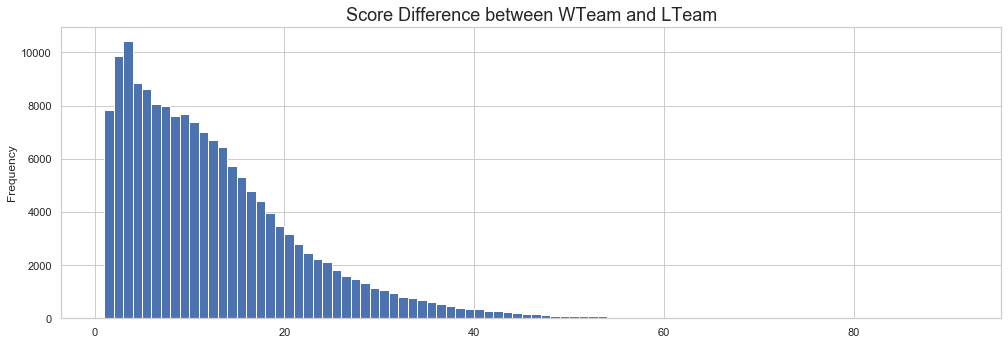

In [22]:
MRegularSeasonCompactResults['ScoreDiff'].plot(kind='hist',
                                              bins=90,
                                              figsize=(15,5))
plt.title('Score Difference between WTeam and LTeam', fontsize=18);

In [23]:
num_winning = MRegularSeasonCompactResults['WTeamName'].value_counts()
num_winning = num_winning.head(20)

#### Pre-Season에서 승리를 가장 많이한 팀

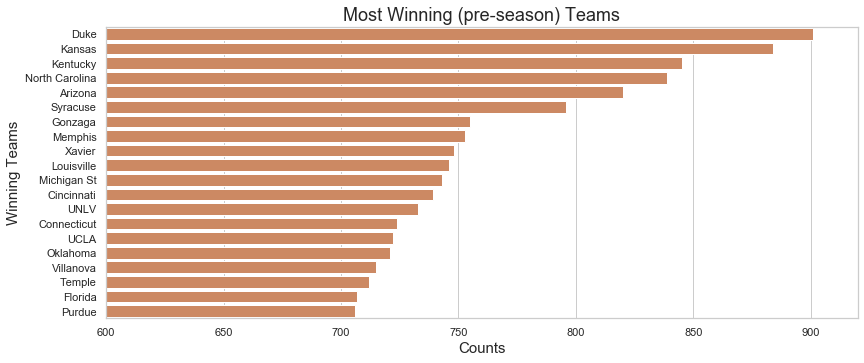

In [24]:
plt.figure(figsize=(12, 5))
counts = MRegularSeasonCompactResults['WTeamName'].value_counts().head(20)
sns.barplot(y=counts.index, x=counts.values, color=second_color, orient='h')

plt.title('Most Winning (pre-season) Teams', fontsize=18); plt.ylabel('Winning Teams', fontsize=15); plt.xlabel('Counts', fontsize=15)
plt.xlim(600, 920);

#### Pre-Season에서 승리를 가장 적게한 팀

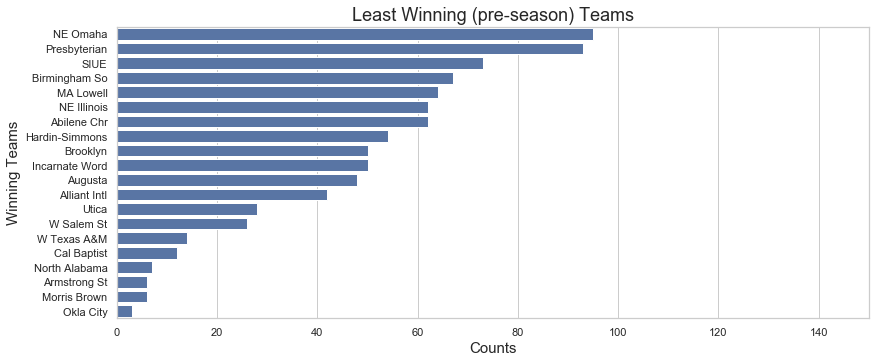

In [25]:
plt.figure(figsize=(12, 5))
counts = MRegularSeasonCompactResults['WTeamName'].value_counts().tail(20)
sns.barplot(y=counts.index, x=counts.values, color=base_color, orient='h')

plt.title('Least Winning (pre-season) Teams', fontsize=18); plt.ylabel('Winning Teams', fontsize=15); plt.xlabel('Counts', fontsize=15)
plt.xlim(0, 150);

#### Pre-Season에서 패배를 가장 많이한 팀

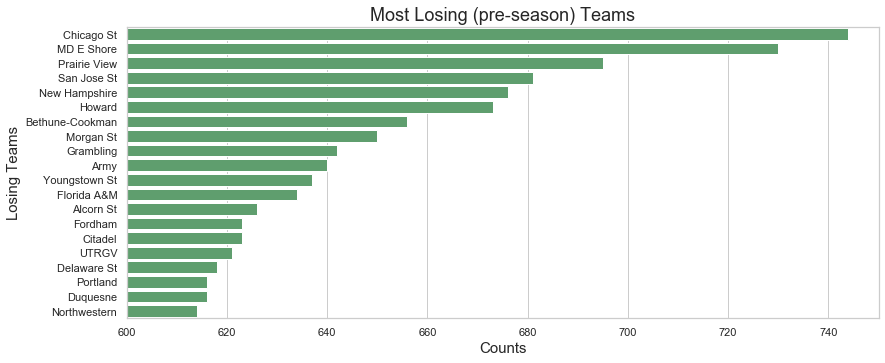

In [26]:
plt.figure(figsize=(12, 5))
counts = MRegularSeasonCompactResults['LTeamName'].value_counts().head(20)
sns.barplot(y=counts.index, x=counts.values, color=third_color, orient='h')

plt.title('Most Losing (pre-season) Teams', fontsize=18); plt.ylabel('Losing Teams', fontsize=15); plt.xlabel('Counts', fontsize=15)
plt.xlim(600, 750);

#### Home팀 승리 횟수와 Away팀 승리 횟수 비교

In [27]:
total_num_of_pre_game = MRegularSeasonCompactResults.shape[0]

MRegularSeasonCompactResults['WLoc'].value_counts() / total_num_of_pre_game

H    0.593481
A    0.304917
N    0.101602
Name: WLoc, dtype: float64

Home팀의 승률이 Away팀의 승률보다 2배 가량 높다는 것을 알 수 있습니다.

In [28]:
MRegularSeasonCompactResults['NumOT'].value_counts()

0    155529
1      4989
2       844
3       152
4        32
5         5
6         1
Name: NumOT, dtype: int64

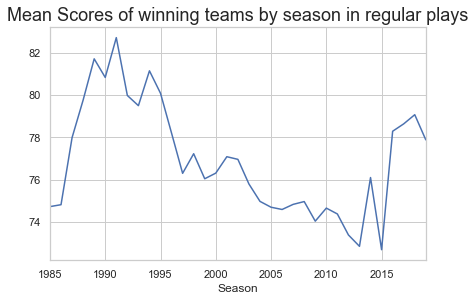

In [29]:
MRegularSeasonCompactResults.groupby(['Season'])['WScore'].mean().plot()
plt.title('Mean Scores of winning teams by season in regular plays', fontsize=18);

## MEvents

In [30]:
# Concatenate MEvents2015, 2016, 2017, 2018, 2019 together
MEvents = pd.concat(dfs['MEvents'], axis=0, sort=False)
MEvents.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,1,2015,11,1103,1420,74,57,0,0,19,1103,100,miss3,unk,0,0,0
1,2,2015,11,1103,1420,74,57,0,0,19,1420,11784,reb,def,0,0,0
2,3,2015,11,1103,1420,74,57,0,0,27,1420,11789,made2,dunk,0,0,0
3,4,2015,11,1103,1420,74,57,0,0,27,1420,11803,assist,NaN,0,0,0
4,5,2015,11,1103,1420,74,57,0,0,59,1103,87,made2,jump,0,0,0


In [31]:
MEvents.shape

(13149684, 17)

#### Event type별 횟수

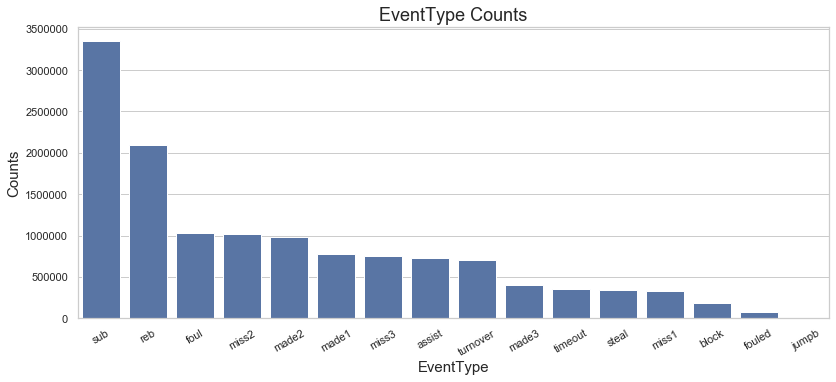

In [32]:
plot_bar_chart(MEvents, 'EventType')
plt.title('EventType Counts', fontsize=18); plt.xlabel('EventType', fontsize=15); plt.ylabel('Counts', fontsize=15)
plt.xticks(rotation=30);

#### Area of Event

In [33]:
area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

MEvents['Area_Name'] = MEvents['Area'].map(area_mapping)

In [34]:
MEvents['counter'] = 1

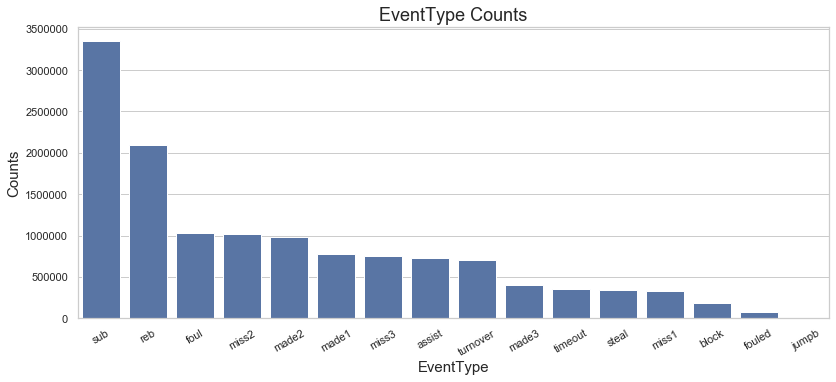

In [35]:
plot_bar_chart(MEvents, 'EventType')
plt.title('EventType Counts', fontsize=18); plt.xlabel('EventType', fontsize=15); plt.ylabel('Counts', fontsize=15)
plt.xticks(rotation=30);

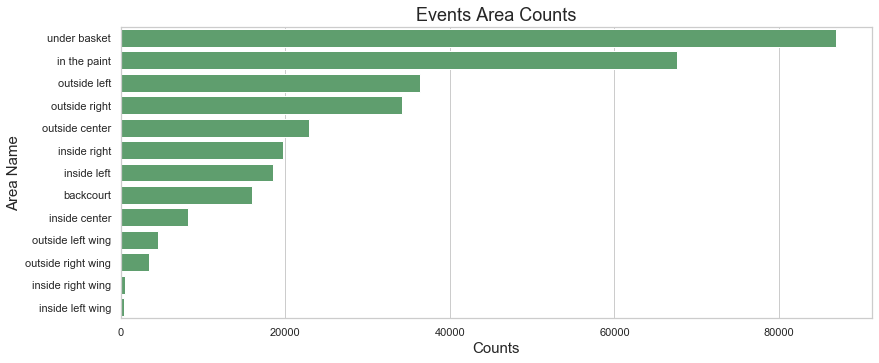

In [36]:
plt.figure(figsize=(12, 5))
counts = MEvents.groupby('Area_Name')['counter'].sum().sort_values(ascending=False)
sns.barplot(y=counts.index, x=counts.values, color=third_color, orient='h')

plt.title('Events Area Counts', fontsize=18); plt.ylabel('Area Name', fontsize=15); plt.xlabel('Counts', fontsize=15);

#### Visualizing Event Area

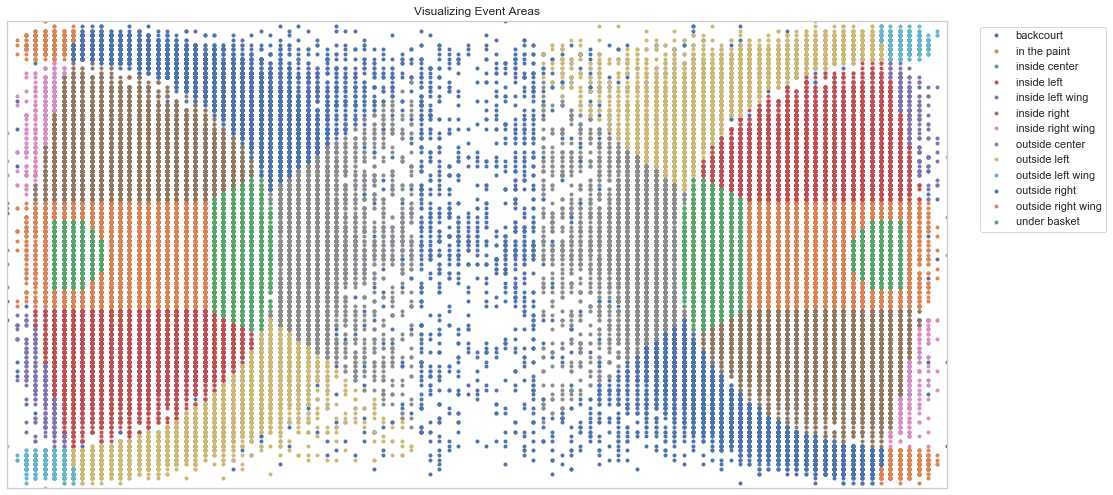

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
for area, df in MEvents.loc[~MEvents['Area_Name'].isna()].groupby('Area_Name'):
    df.plot(x='X', y='Y', style='.', label=area, ax=ax, title='Visualizing Event Areas')
    ax.legend()
plt.legend(bbox_to_anchor=(1.03,1), loc="upper left")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100);

#### Normalizing X, Y Data
코트의 너비는 50피트, 길이는 94피트이므로 이에 맞게 X, Y 데이터를 정규화 합니다.

In [38]:
MEvents['X_'] = (MEvents['X'] * (94/100))
MEvents['Y_'] = (MEvents['Y'] * (50/100))

### NCAA Court Plot Function

In [39]:
def create_ncaa_full_court(ax=None, three_line='mens', court_color='#edc993',
                           lw=3, lines_color='black', lines_alpha=0.5,
                           paint_fill='blue', paint_alpha=0.4):
    """
    Creates NCAA Basketball
    Dimensions are in feet (Court is 97x50 ft)
    Created by: Rob Mulla / https://github.com/RobMulla

    * Note that this function uses "feet" as the unit of measure.
    * NCAA Data is provided on a x range: 0, 100 and y-range 0 to 100
    * To plot X/Y positions first convert to feet like this:
    ```
    Events['X_'] = (Events['X'] * (94/100))
    Events['Y_'] = (Events['Y'] * (50/100))
    ```

    three_line: 'mens', 'womens' or 'both' defines 3 point line plotted
    court_color : (hex) Color of the court
    lw : line width
    lines_color : Color of the lines
    paint_fill : Color inside the paint
    paint_alpha : transparency of the "paint"
    """
    if ax is None:
        ax = plt.gca()

    # Create Pathes for Court Lines
    center_circle = Circle((94/2, 50/2), 6,
                           linewidth=lw, color=lines_color, lw=lw,
                           fill=False, alpha=lines_alpha)
#     inside_circle = Circle((94/2, 50/2), 2,
#                            linewidth=lw, color=lines_color, lw=lw,
#                            fill=False, alpha=lines_alpha)

    hoop_left = Circle((5.25, 50/2), 1.5 / 2,
                       linewidth=lw, color=lines_color, lw=lw,
                       fill=False, alpha=lines_alpha)
    hoop_right = Circle((94-5.25, 50/2), 1.5 / 2,
                        linewidth=lw, color=lines_color, lw=lw,
                        fill=False, alpha=lines_alpha)

    # Paint - 18 Feet 10 inches which converts to 18.833333 feet - gross!
    left_paint = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=paint_fill, alpha=paint_alpha,
                           lw=lw, edgecolor=None)
    right_paint = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=paint_fill, alpha=paint_alpha,
                            lw=lw, edgecolor=None)
    
    left_paint_boarder = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=False, alpha=lines_alpha,
                           lw=lw, edgecolor=lines_color)
    right_paint_boarder = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=False, alpha=lines_alpha,
                            lw=lw, edgecolor=lines_color)

    left_arc = Arc((18.833333, 50/2), 12, 12, theta1=-
                   90, theta2=90, color=lines_color, lw=lw,
                   alpha=lines_alpha)
    right_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=90,
                    theta2=-90, color=lines_color, lw=lw,
                    alpha=lines_alpha)
    
    leftblock1 = Rectangle((7, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    leftblock2 = Rectangle((7, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(leftblock1)
    ax.add_patch(leftblock2)
    
    left_l1 = Rectangle((11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l2 = Rectangle((14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l3 = Rectangle((17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l1)
    ax.add_patch(left_l2)
    ax.add_patch(left_l3)
    left_l4 = Rectangle((11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l5 = Rectangle((14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l6 = Rectangle((17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l4)
    ax.add_patch(left_l5)
    ax.add_patch(left_l6)
    
    rightblock1 = Rectangle((94-7-1, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    rightblock2 = Rectangle((94-7-1, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(rightblock1)
    ax.add_patch(rightblock2)

    right_l1 = Rectangle((94-11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l2 = Rectangle((94-14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l3 = Rectangle((94-17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l1)
    ax.add_patch(right_l2)
    ax.add_patch(right_l3)
    right_l4 = Rectangle((94-11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l5 = Rectangle((94-14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l6 = Rectangle((94-17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l4)
    ax.add_patch(right_l5)
    ax.add_patch(right_l6)
    
    # 3 Point Line
    if (three_line == 'mens') | (three_line == 'both'):
        # 22' 1.75" distance to center of hoop
        three_pt_left = Arc((6.25, 50/2), 44.291, 44.291, theta1=-78,
                            theta2=78, color=lines_color, lw=lw,
                            alpha=lines_alpha)
        three_pt_right = Arc((94-6.25, 50/2), 44.291, 44.291,
                             theta1=180-78, theta2=180+78,
                             color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 feet max to sideline for mens
        ax.plot((0, 11.25), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((0, 11.25), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.add_patch(three_pt_left)
        ax.add_patch(three_pt_right)

    if (three_line == 'womens') | (three_line == 'both'):
        # womens 3
        three_pt_left_w = Arc((6.25, 50/2), 20.75 * 2, 20.75 * 2, theta1=-85,
                              theta2=85, color=lines_color, lw=lw, alpha=lines_alpha)
        three_pt_right_w = Arc((94-6.25, 50/2), 20.75 * 2, 20.75 * 2,
                               theta1=180-85, theta2=180+85,
                               color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 inches max to sideline for mens
        ax.plot((0, 8.3), (4.25, 4.25), color=lines_color,
                lw=lw, alpha=lines_alpha)
        ax.plot((0, 8.3), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (4.25, 4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)

        ax.add_patch(three_pt_left_w)
        ax.add_patch(three_pt_right_w)

    # Add Patches
    ax.add_patch(left_paint)
    ax.add_patch(left_paint_boarder)
    ax.add_patch(right_paint)
    ax.add_patch(right_paint_boarder)
    ax.add_patch(center_circle)
#     ax.add_patch(inside_circle)
    ax.add_patch(hoop_left)
    ax.add_patch(hoop_right)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

    # Restricted Area Marker
    restricted_left = Arc((6.25, 50/2), 8, 8, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha)
    restricted_right = Arc((94-6.25, 50/2), 8, 8,
                         theta1=180-90, theta2=180+90,
                         color=lines_color, lw=lw, alpha=lines_alpha)
    ax.add_patch(restricted_left)
    ax.add_patch(restricted_right)
    
    # Backboards
    ax.plot((4, 4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((94-4, 94-4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((4, 4.6), (50/2, 50/2), color=lines_color,
            lw=lw, alpha=lines_alpha)
    ax.plot((94-4, 94-4.6), (50/2, 50/2),
            color=lines_color, lw=lw, alpha=lines_alpha)

    # Half Court Line
    ax.axvline(94/2, color=lines_color, lw=lw, alpha=lines_alpha)

    # Boarder
    boarder = Rectangle((0.3,0.3), 94-0.6, 50-0.6, fill=False, lw=3, color='black', alpha=lines_alpha)
    ax.add_patch(boarder)
    
    # Plot Limit
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)
    ax.set_facecolor(court_color)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    return ax

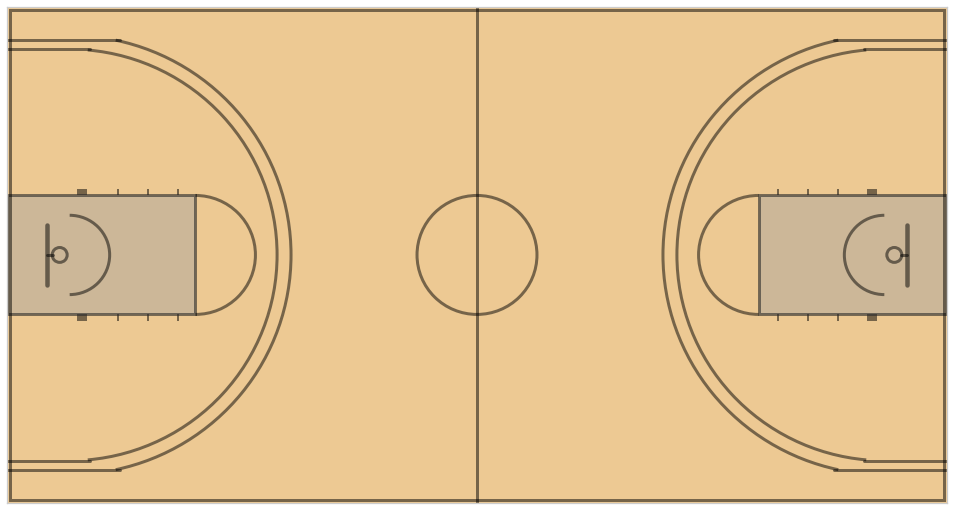

In [40]:
fig, ax = plt.subplots(figsize=(15, 8.5))
create_ncaa_full_court(ax, three_line='both', paint_alpha=0.2);

#### Turnover 위치

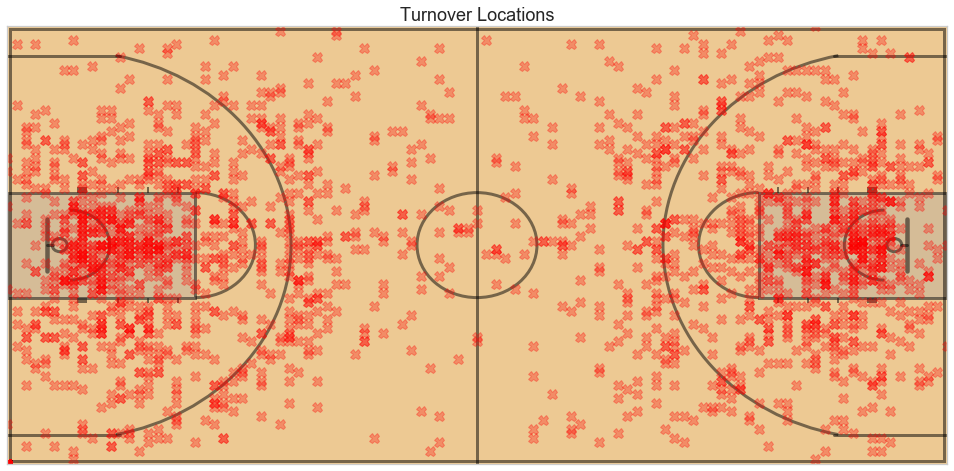

In [41]:
fig, ax = plt.subplots(figsize=(15, 7.5))
marker_size = 10
ax = create_ncaa_full_court(ax, paint_alpha=0.15)
MEvents.loc[MEvents['EventType'] == 'turnover'].plot(x='X_',
                                                    y='Y_',
                                                    style='X',
                                                    c='red',
                                                    alpha=0.3,
                                                    markersize=marker_size,
                                                    ax=ax)
ax.set_title('Turnover Locations', fontsize=18)
ax.set_xlabel('')
ax.get_legend().remove();

In [42]:
num_of_total_rows = MEvents.loc[MEvents['EventType'] == 'turnover'].shape[0]
num_of_total_rows

707561

In [43]:
turnover = MEvents.loc[MEvents['EventType'] == 'turnover']
num_of_not_zero_X_rows = turnover.loc[turnover['X_'] != 0].shape[0]
num_of_not_zero_X_rows

2044

In [44]:
print(f'총 {num_of_total_rows}개의 rows가 있지만 {num_of_not_zero_X_rows}개만이 0이 아닌 X_를 가지고 있어, plot된 점이 적습니다.')

총 707561개의 rows가 있지만 2044개만이 0이 아닌 X_를 가지고 있어, plot된 점이 적습니다.


#### 3점 슛을 성공한 위치

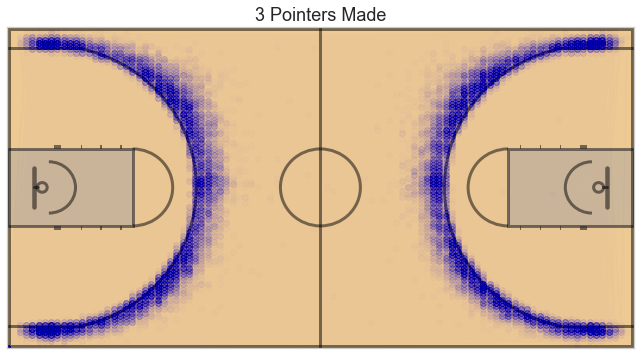

In [45]:
matplotlib.rcParams['agg.path.chunksize']=100000

if DEBUG:
    alpha = 0.4
    style = 'X'
else:
    alpha = 0.01
    style = 'o'

fig, ax = plt.subplots(figsize=(10, 5.5))
ax = create_ncaa_full_court(ax, paint_alpha=0.2)
MEvents.loc[MEvents['EventType'] == 'made3'].plot(x='X_',
                                                 y='Y_',
                                                 marker=style,
                                                 color='blue',
                                                 alpha=alpha,
                                                 ax=ax)
ax.set_title('3 Pointers Made', fontsize=18)
ax.set_xlabel('')
ax.get_legend().remove();

#### 3점 슛을 실패한 위치

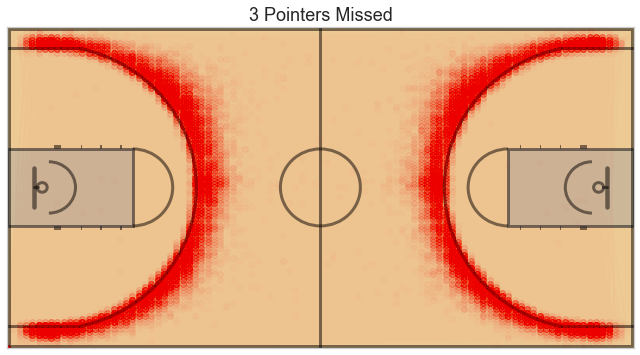

In [46]:
fig2, ax2 = plt.subplots(figsize=(10, 5.5))
ax2 = create_ncaa_full_court(ax2, paint_alpha=0.2)
MEvents.loc[MEvents['EventType']=='miss3'].plot(x='X_',
                                                y='Y_',
                                                marker=style,
                                                color='red',
                                                alpha=alpha,
                                                ax=ax2)
ax2.set_title('3 Pointers Missed', fontsize=18)
ax2.set_xlabel('')
ax2.get_legend().remove();

#### 2점 슛을 성공한 위치

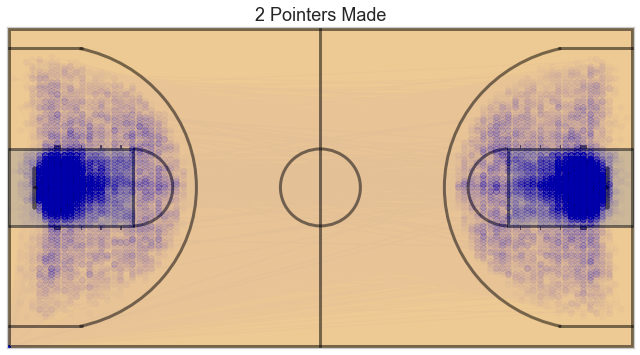

In [47]:
fig3, ax3 = plt.subplots(figsize=(10, 5.5))
ax3 = create_ncaa_full_court(ax3, paint_alpha=0.2)
MEvents.loc[MEvents['EventType'] == 'made2'].plot(x='X_',
                                                 y='Y_',
                                                 marker=style,
                                                 color='blue',
                                                 alpha=alpha,
                                                 ax=ax3)
ax3.set_title('2 Pointers Made', fontsize=18)
ax3.set_xlabel('')
ax3.get_legend().remove()

#### 2점 슛을 실패한 위치

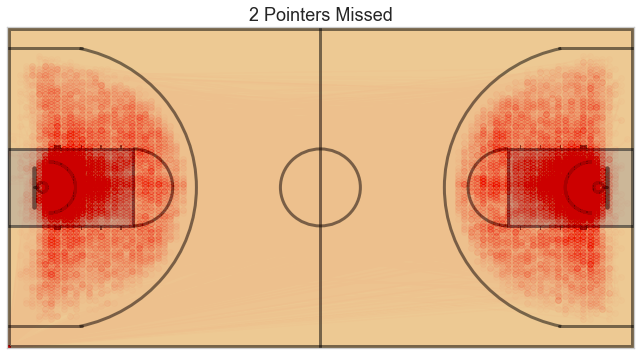

In [48]:
fig, ax = plt.subplots(figsize=(10, 5.5))
ax = create_ncaa_full_court(ax, paint_alpha=0.2)
MEvents.loc[MEvents['EventType'] == 'miss2'].plot(x='X_',
                                                 y='Y_',
                                                 marker=style,
                                                 color='red',
                                                 alpha=alpha,
                                                 ax=ax)
ax.set_title('2 Pointers Missed', fontsize=18)
ax.set_xlabel('')
ax.get_legend().remove();

## MPlayers

In [49]:
# Merge events and MPlayers
MEvents = MEvents.merge(dfs['Misc']['MPlayers'],
             how='left',
             left_on = ['EventTeamID', 'EventPlayerID'],
             right_on = ['TeamID', 'PlayerID'])

In [50]:
MEvents.drop(['PlayerID', 'TeamID'], axis=1, inplace=True)
MEvents.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,...,EventSubType,X,Y,Area,Area_Name,counter,X_,Y_,LastName,FirstName
0,1,2015,11,1103,1420,74,57,0,0,19,...,unk,0,0,0,NaN,1,0.0,0.0,McAdams,Reggie
1,2,2015,11,1103,1420,74,57,0,0,19,...,def,0,0,0,NaN,1,0.0,0.0,Grant,Jourdan
2,3,2015,11,1103,1420,74,57,0,0,27,...,dunk,0,0,0,NaN,1,0.0,0.0,Joyce,Cody
3,4,2015,11,1103,1420,74,57,0,0,27,...,NaN,0,0,0,NaN,1,0.0,0.0,Sparow,Wayne
4,5,2015,11,1103,1420,74,57,0,0,59,...,jump,0,0,0,NaN,1,0.0,0.0,Forsythe,Pat


`LastName`과 `FirstName`이 잘 결합되었습니다.

#### Full Name 만들기

In [51]:
MEvents['FullName'] = MEvents['FirstName'] + ' ' + MEvents['LastName']

### Plotting Specific Player's Made/Missed Shots

유명한 선수의 슛 성공 및 실패 위치를 코트 위에 그려봅니다.

#### Mamadi Diakite's 2 points Made/Missed

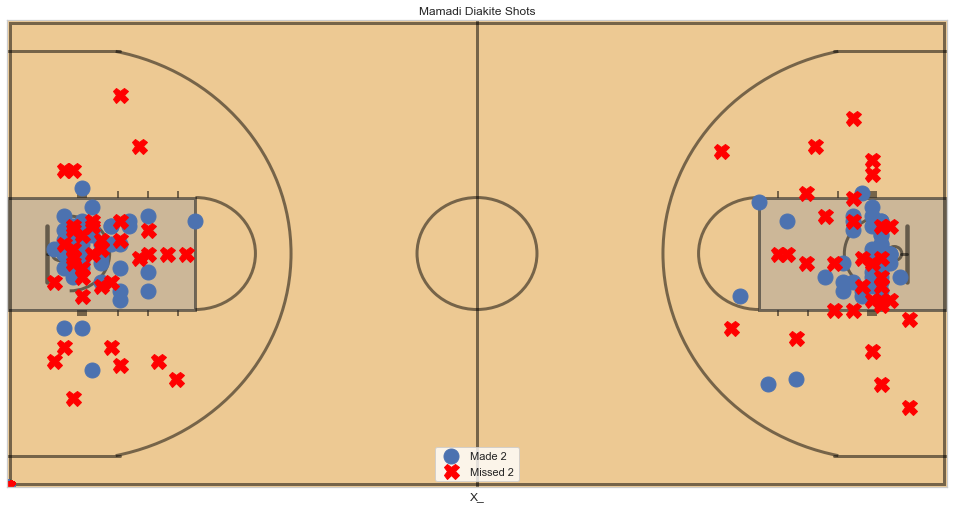

In [52]:
marker_size = 15

first_name = 'Mamadi'
last_name = 'Diakite'

fig, ax = plt.subplots(figsize=(15, 8))
ax = create_ncaa_full_court(ax, paint_alpha=0.2)
MEvents.query('FirstName == @first_name and LastName == @last_name and EventType == "made2"') \
    .plot(x='X_', y='Y_', style='o', label='Made 2',
         markersize=marker_size, ax=ax);

MEvents.query('FirstName == @first_name and LastName == @last_name and EventType == "miss2"') \
    .plot(x='X_', y='Y_', style='X', label='Missed 2',
         color='red', markersize=marker_size, ax=ax);
plt.legend(loc='lower center')
plt.title('Mamadi Diakite Shots');

#### Kyle Guy's 2 points Made/Missed

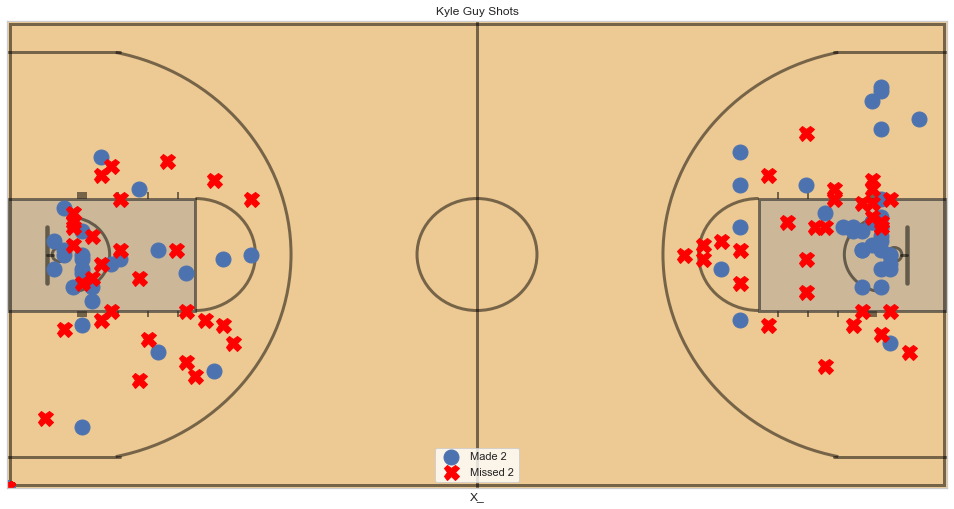

In [53]:
marker_size = 15

first_name = 'Kyle'
last_name = 'Guy'

# first_name = 'Zion'
# last_name = 'Williamson'

fig, ax = plt.subplots(figsize=(15, 8))
ax = create_ncaa_full_court(ax, paint_alpha=0.2)
MEvents.query('FirstName == @first_name and LastName == @last_name and EventType == "made2"') \
    .plot(x='X_', y='Y_', style='o', label='Made 2',
         markersize=marker_size, ax=ax);

MEvents.query('FirstName == @first_name and LastName == @last_name and EventType == "miss2"') \
    .plot(x='X_', y='Y_', style='X', label='Missed 2',
         color='red', markersize=marker_size, ax=ax);
plt.legend(loc='lower center')
plt.title('Kyle Guy Shots');

#### Aaron Henry's 3 points Made/Missed (One of the best 3-pointers)

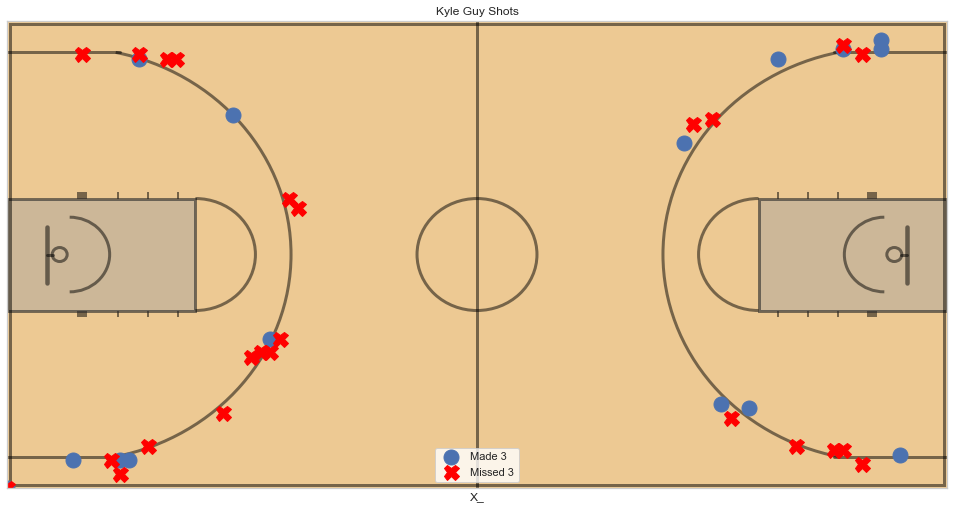

In [54]:
marker_size = 15

# Best Shooting Guard
first_name = 'Aaron'
last_name = 'Henry'

fig, ax = plt.subplots(figsize=(15, 8))
ax = create_ncaa_full_court(ax, paint_alpha=0.2)
MEvents.query('FirstName == @first_name and LastName == @last_name and EventType == "made3"') \
    .plot(x='X_', y='Y_', style='o', label='Made 3',
         markersize=marker_size, ax=ax);

MEvents.query('FirstName == @first_name and LastName == @last_name and EventType == "miss3"') \
    .plot(x='X_', y='Y_', style='X', label='Missed 3',
         color='red', markersize=marker_size, ax=ax);
plt.legend(loc='lower center')
plt.title('Kyle Guy Shots');

### Shot Heatmap

#### 슛을 시도한 횟수를 Heatmap으로 표현 (성공, 실패한 슛 모두  포함)

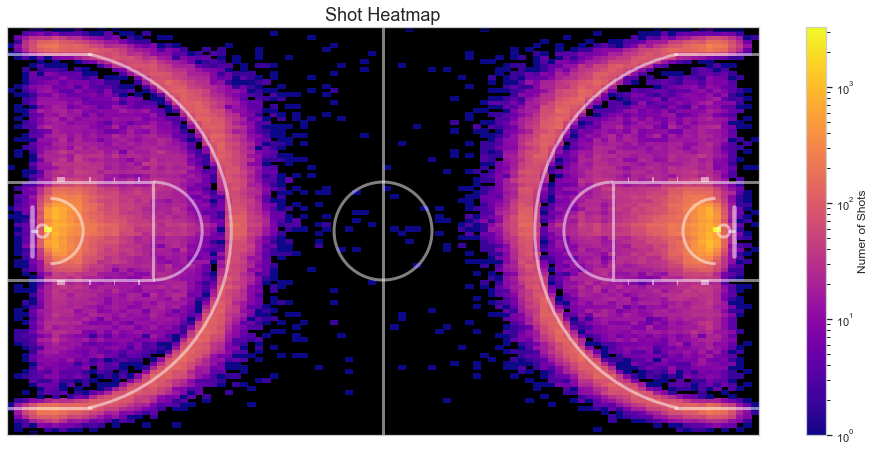

In [55]:
N_bins=100
shot_events = MEvents.loc[MEvents['EventType'].isin(['miss3','made3','miss2','made2']) & (MEvents['X_'] != 0)]
fig, ax = plt.subplots(figsize=(15, 7))
ax = create_ncaa_full_court(ax=ax,
                            paint_alpha=0.0,
                            court_color='black',
                            lines_color='white')
plt.hist2d(shot_events['X_'].values, 
           shot_events['Y_'].values,
           bins=N_bins, norm=matplotlib.colors.LogNorm(),
           cmap='plasma')

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Numer of Shots')
ax.set_title('Shot Heatmap', fontsize=18);

## Reference: 
- https://www.kaggle.com/robikscube/2020-march-madness-data-first-look-eda